This notebook is tested on my UMN laptop in the sunpyenv.
It is based on my previous notebook "Extract one jet from SJH catalogue" and from https://github.com/ramanakumars/SolarJets/blob/main/Jet_statistics.ipynb

## Load and read SJH catalogue

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [27]:
json_file = 'Jet_clusters_3.0_2.0_paperID_cluster_xy_v2.json'

In [28]:
from utils.Jet_class_light import json_import_list

In [29]:
Jet_clusters=json_import_list(json_file)

The 881 JetCluster objects are imported from Jet_clusters_3.0_2.0_paperID_cluster_xy_v2.json.


In [5]:
# Here we have the same format as for the CSV file information
sjh_identifier = np.array([Jet_clusters[i].ID for i in range(len(Jet_clusters))], dtype=str)

# date: Observation time of the start of the jet (format YYYY-MM-DDThh:mm:ss)
Cluster_date = np.array([Jet_clusters[i].obs_time for i in range(len(Jet_clusters))], dtype='datetime64')
# duration of the jet (minutes)
stat_dur = np.array([Jet_clusters[i].Duration for i in range(len(Jet_clusters))], dtype=float)

Cluster_SOL = np.array([Jet_clusters[i].SOL for i in range(len(Jet_clusters))], dtype=str)

stat_Bx = np.array([Jet_clusters[i].Bx for i in range(len(Jet_clusters))], dtype=float)
stat_By = np.array([Jet_clusters[i].By for i in range(len(Jet_clusters))], dtype=float)
stat_Lon = np.array([Jet_clusters[i].Lon for i in range(len(Jet_clusters))], dtype=float)
stat_Lat = np.array([Jet_clusters[i].Lat for i in range(len(Jet_clusters))], dtype=float)
stat_H = np.array([Jet_clusters[i].Max_Height for i in range(len(Jet_clusters))], dtype=float)
stat_W = np.array([Jet_clusters[i].Width for i in range(len(Jet_clusters))], dtype=float)
stat_vel = np.array([Jet_clusters[i].Velocity for i in range(len(Jet_clusters))], dtype=float)
stat_sigma = np.array([Jet_clusters[i].sigma for i in range(len(Jet_clusters))], dtype=float)
std_H = np.array([Jet_clusters[i].std_maxH for i in range(len(Jet_clusters))], dtype=float)
std_W = np.array([Jet_clusters[i].std_W for i in range(len(Jet_clusters))], dtype=float)
std_Bx = np.array([Jet_clusters[i].std_Bx for i in range(len(Jet_clusters))], dtype=float)
std_By = np.array([Jet_clusters[i].std_By for i in range(len(Jet_clusters))], dtype=float)
flags = np.array([Jet_clusters[i].flag for i in range(len(Jet_clusters))], dtype=str)
#angle = np.array([Jet_clusters[i].angle for i in range(len(Jet_clusters))], dtype=float)

## Some box definitions

In [6]:
from utils.Jet_box_class import make_cluster_box, make_subject_box, plot_all_subject_boxes_and_average_box

## Choose one jet and get the data

### Choose one jet

In [7]:
from astropy.coordinates import SkyCoord
import sunpy.coordinates  # Needed for helioprojective coordinate frame
from sunpy.net import Fido
from sunpy.net import attrs as a
jsoc_email = "insert jsoc verified mail adress"

c:\Users\adrie\anaconda3\envs\ML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:
jetid = 0

print(sjh_identifier[jetid])
selected_jet = Jet_clusters[jetid]

jet_box = make_cluster_box(selected_jet)

jet_start_time = selected_jet.obs_time
jet_end_time = selected_jet.obs_time + np.timedelta64(int(selected_jet.Duration*60), 's')
print(jet_start_time)
print(jet_end_time)

sjh_2011-01-20T09_1
2011-01-20T09:15:44.000000
2011-01-20T09:59:20.000000


In [53]:
import math
import astropy.units as u
from astropy.coordinates import Angle
heights = []
angles = []
for jet in selected_jet.jets:
    heights.append(jet.height)
    angles.append(jet.angle)
jet_box_angle = angles[heights.index(max(heights))]
print(jet_box_angle)
jet_box_angle = np.mean(angles)
print(jet_box_angle)
print(Angle(jet_box_angle-math.pi/2, u.radian))


-2.567716903654209
-2.567716903654209
-4.13851 rad


In [37]:
jet_box.angle

<Angle -3.54686098 rad>

### OPTIONAL: IF NEEDED, download the data (otherwise, skip)

Calculating the coordinates of the FOV for the cutout

In [38]:
print(jet_box.base, jet_box.height)
cutout_half_side = 60 if jet_box.height.value < 60 else jet_box.height.value + 20
print(cutout_half_side)
x1 = jet_box.base[0].value - cutout_half_side
x2 = jet_box.base[0].value + cutout_half_side
y1 = jet_box.base[1].value - cutout_half_side
y2 = jet_box.base[1].value + cutout_half_side

[-226.577125 -956.964375] arcsec 177.40686087352992 arcsec
197.40686087352992


Query the cutout

In [39]:
bottom_left = SkyCoord(x1*u.arcsec, y1*u.arcsec, obstime=jet_start_time, observer="earth", frame="helioprojective")
top_right = SkyCoord(x2*u.arcsec, y2*u.arcsec, obstime=jet_start_time, observer="earth", frame="helioprojective")

In [40]:
cutout = a.jsoc.Cutout(bottom_left, top_right=top_right, tracking=False)

In [49]:
query = Fido.search(
    a.Time(jet_start_time, jet_end_time),
    a.Wavelength(304*u.angstrom),
    a.Sample(24*u.s),
    a.jsoc.Series.aia_lev1_euv_12s,
    a.jsoc.Notify(jsoc_email),
    a.jsoc.Segment.image,
    cutout,
)
print(query)

Results from 1 Provider:

80 Results from the JSOCClient:
Source: http://jsoc.stanford.edu

       T_REC         TELESCOP INSTRUME WAVELNTH CAR_ROT
-------------------- -------- -------- -------- -------
2015-09-22T21:56:00Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:56:24Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:56:48Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:57:12Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:57:36Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:58:00Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:58:24Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:58:48Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:59:12Z  SDO/AIA    AIA_4      304    2168
2015-09-22T21:59:36Z  SDO/AIA    AIA_4      304    2168
                 ...      ...      ...      ...     ...
2015-09-22T22:23:36Z  SDO/AIA    AIA_4      304    2168
2015-09-22T22:24:00Z  SDO/AIA    AIA_4      304    2168
2015-09-22T22:24:24Z  SDO/AIA    AIA_4      304    2168
2015-09-22T2

Download

In [50]:
files = Fido.fetch(query, overwrite=False, path=data_path)
files.sort()

Export request pending. [id=JSOC_20240422_004201, status=2]
Waiting for 0 seconds...
Export request pending. [id=JSOC_20240422_004201, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240422_004201, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240422_004201, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240422_004201, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240422_004201, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240422_004201, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240422_004201, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240422_004201, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240422_004201, status=1]
Waiting for 5 seconds...
80 URLs found for download. Full request totalling 22MB


Files Downloaded:   0%|                                                                       | 0/80 [01:08<?, ?file/s]

80/0 files failed to download. Please check `.errors` for details


## Plot jet (one frame)

In [41]:
import glob
from sunpy import map
import astropy.units as u

In [42]:
files = glob.glob(f"./essai_data1/{str(jetid).zfill(3)}/aia.lev1_euv_12s.*.304.image.fits")
len(files)

110

In [43]:
aia_map = sunpy.map.Map(files[0])
jet_box.base

<Quantity [-226.577125, -956.964375] arcsec>

In [44]:
jet_base_coord = SkyCoord(jet_box.base[0], jet_box.base[1], 
                                  obstime=aia_map.date, 
                                  observer="earth", 
                                  frame="helioprojective")
jet_base_coord

<SkyCoord (Helioprojective: obstime=2011-01-20T09:15:44.123, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (Tx, Ty) in arcsec
    (-226.577125, -956.964375)>

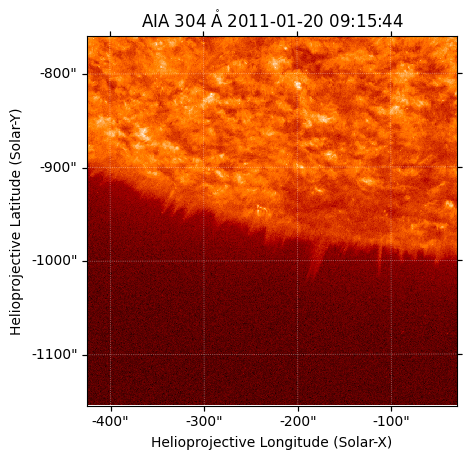

In [45]:
### fig = plt.figure(dpi=150) ### export quality
fig = plt.figure()
ax = fig.add_subplot(projection=aia_map)

image = aia_map.plot(axes=ax)

plt.show()

## Plot jet and box

### Average box

In [46]:
rectangle_center_coord = SkyCoord(jet_box.center()[0], jet_box.center()[1], 
                                  obstime=aia_map.date, 
                                  observer="earth", 
                                  frame="helioprojective")

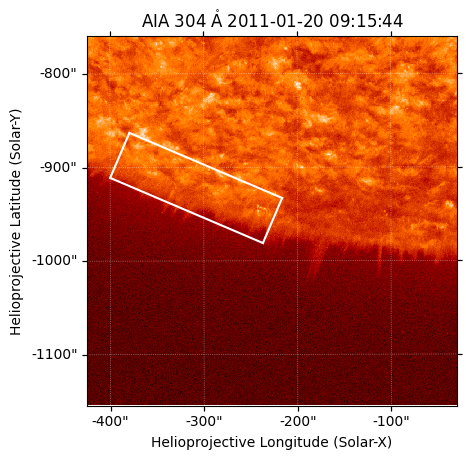

In [47]:
fig = plt.figure()
ax = fig.add_subplot(projection=aia_map)
image = aia_map.plot(axes=ax)

# Note that the coordinates need to be in degrees rather than arcseconds.
for line in jet_box.lines_to_plot():
    ax.plot(line[0]*u.arcsec.to(u.deg), line[1]*u.arcsec.to(u.deg),
            color='white',
            transform=ax.get_transform("world"))

#ax.plot_coord(rectangle_center_coord, marker='o', color='white')
plt.show()

### Plot all boxes

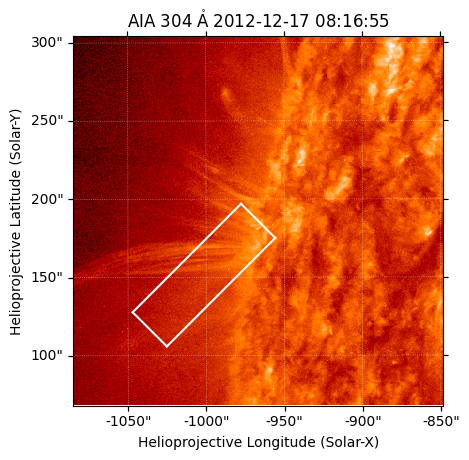

In [25]:
plot_all_subject_boxes_and_average_box(selected_jet, jet_box, aia_map)

### Plot box specifically associated to this frame

Find which subject (a subject = a sequence of 15 frames) is associated with this frame

In [19]:
subjects_start_time = []
for jet in Jet_clusters[jetid].jets:
    subjects_start_time.append(jet.time)

In [20]:
subject_idn = np.max(np.where(subjects_start_time < aia_map.date.datetime64))

In [21]:
Jet_clusters[jetid].jets[subject_idn].time

numpy.datetime64('2011-01-20T09:36:32.000000')

Make the box associated to this subject

In [22]:
subject_box = make_subject_box(Jet_clusters[jetid].jets[subject_idn])

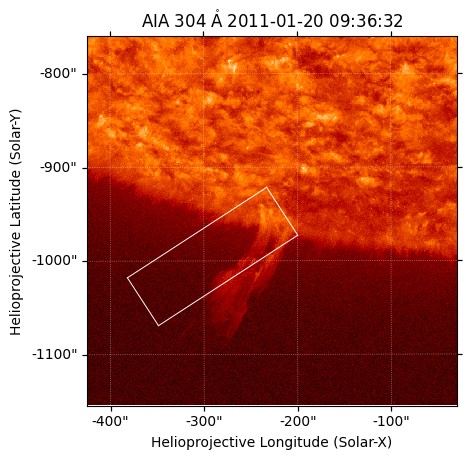

In [23]:
fig = plt.figure()
ax = fig.add_subplot(projection=aia_map)
image = aia_map.plot(axes=ax)

# Note that the coordinates need to be in degrees rather than arcseconds.
for line in subject_box.lines_to_plot():
    ax.plot(line[0]*u.arcsec.to(u.deg), line[1]*u.arcsec.to(u.deg),
            color='white', linewidth=0.7,
            transform=ax.get_transform("world"))
    
plt.show()

In [24]:
subject_box.corners()

[[<Quantity -199.68405621 arcsec>, <Quantity -972.72435775 arcsec>],
 [<Quantity -232.78794379 arcsec>, <Quantity -921.51564225 arcsec>],
 [<Quantity -348.67090181 arcsec>, <Quantity -1069.03694323 arcsec>],
 [<Quantity -381.7747894 arcsec>, <Quantity -1017.82822773 arcsec>]]

In [25]:
len(subjects_start_time)

8

## Check if any other jet is reported in this frame
### Find other jets in the catalogue happening at the time of the AIA frame

Extract AIA frame date

In [26]:
aia_frame_date = aia_map.date.datetime64

We already have jet start time and jet duration, make an array with the jet end times

In [27]:
jet_end_times = Cluster_date + (stat_dur*60).astype('timedelta64[s]')

Check if there are any other jet in the catalogue that match the aia frame time and print relevant times. Note that you will find the current jet too! I am keeping everything as it is simple.

In [28]:
# Finding all jets that exist for this data frame
matching_time_jets = np.where(np.array([Cluster_date < aia_frame_date])*np.array([jet_end_times > aia_frame_date]))[1]
print(aia_frame_date)
for jetindice in matching_time_jets:
    print(Cluster_date[jetindice], jet_end_times[jetindice])
if len(matching_time_jets) == 1:
    print('No additional jet found in this time frame')
else:
    print(len(matching_time_jets)-1, 'additional jet(s) found')

2011-01-20T09:36:32.123000000
2011-01-20T09:15:44.000000 2011-01-20T09:59:20.000000
No additional jet found in this time frame


### If jets where found, now check if their box overlap with the AIA frame
Extract FOV corners from the AIA cutout and make a polygon

In [29]:
from shapely.geometry import Polygon

In [30]:
xmin = aia_map.bottom_left_coord.Tx.value
ymin = aia_map.bottom_left_coord.Ty.value
xmax = aia_map.top_right_coord.Tx.value
ymax = aia_map.top_right_coord.Ty.value
poly_cutout_fov = Polygon([(xmin,ymin), (xmin,ymax), (xmax,ymax), (xmax,ymin)])

For each jet, extract the box associated with that frame, create a polygon, and check if there is intersection with the cutout FOV

In [31]:
jet_in_fov = []
jet_boxes = []
for jetindice in matching_time_jets:
    # find the subject associated with the aia frame
    subjects_start_time_temp = []
    for jet in Jet_clusters[jetindice].jets:
        subjects_start_time_temp.append(jet.time)
    subject_idn_temp = np.max(np.where(subjects_start_time_temp < aia_map.date.datetime64))
    # extract corresponding box
    subject_box_temp = make_subject_box(Jet_clusters[jetindice].jets[subject_idn_temp])
    # make polygon
    jet_poly_temp = Polygon(subject_box_temp.corners(no_unit=True))
    # check if intersection
    jet_in_fov.append(poly_cutout_fov.intersects(jet_poly_temp))
    # if intersection, keep the box for further analysis
    if poly_cutout_fov.intersects(jet_poly_temp):
        jet_boxes.append(subject_box_temp)

TypeError: Jet_box.corners() got an unexpected keyword argument 'no_unit'

In [45]:
jet_boxes

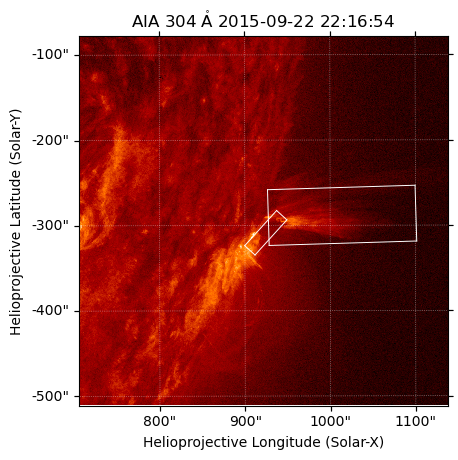

In [46]:
fig = plt.figure()
ax = fig.add_subplot(projection=aia_map)
image = aia_map.plot(axes=ax)

## Plot all the boxes that were found - this should include the original jet

for additional_box in jet_boxes:
    for line in additional_box.lines_to_plot():
        ax.plot(line[0]*u.arcsec.to(u.deg), line[1]*u.arcsec.to(u.deg),
                color='white', linewidth=0.7,
                transform=ax.get_transform("world")) 

plt.show()